In [82]:
import pandas as pd

# -*- coding: utf-8 -*-
"""
@name: Week 3 Poisson GLM.py
@author: Ming-Long Lam, Ph.D.
@organization: University of Chicago
"""
import matplotlib.pyplot as plt
import numpy
import pandas
import sys
# Set some options for printing all the columns
numpy.set_printoptions(precision = 10, threshold = sys.maxsize)
numpy.set_printoptions(linewidth = numpy.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10}'.format
import seaborn as sns
import math
from scipy.stats import chi2
sys.path.append('C:\\MScAnalytics\\Linear and Nonlinear Model\\Job')
import Regression

In [140]:
target = 'CLM_COUNT'
exposure = 'EXPOSURE'
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED","URBANICITY",'HOMEKIDS', 'KIDSDRIV',"AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
cat_cols = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY"]
claim_history = pandas.read_excel('claim_history.xlsx')
claim_history[["BLUEBOOK","HOME_VAL","INCOME"]] = claim_history[["BLUEBOOK","HOME_VAL","INCOME"]]/1000
train_data = claim_history[claim_history['EXPOSURE'] > 0.0] # Only positive

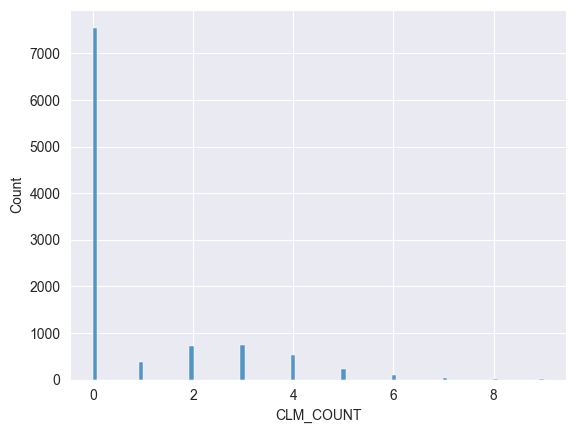

In [25]:
q1a = sns.histplot(train_data["CLM_COUNT"])

In [141]:
train_data = train_data[[target] + [exposure] + int_pred]   # Only necessary
train_data = train_data.dropna().reset_index()              # Remove missing values
# Missing value situation
train_data.isnull().sum()

index         0
CLM_COUNT     0
EXPOSURE      0
CAR_TYPE      0
CAR_USE       0
EDUCATION     0
GENDER        0
MSTATUS       0
PARENT1       0
RED_CAR       0
REVOKED       0
URBANICITY    0
HOMEKIDS      0
KIDSDRIV      0
AGE           0
BLUEBOOK      0
CAR_AGE       0
HOME_VAL      0
INCOME        0
YOJ           0
MVR_PTS       0
TIF           0
TRAVTIME      0
dtype: int64

C:\Users\yomaa\AppData\Local\Temp\ipykernel_17268\1276063758.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10,8), dpi = 200)


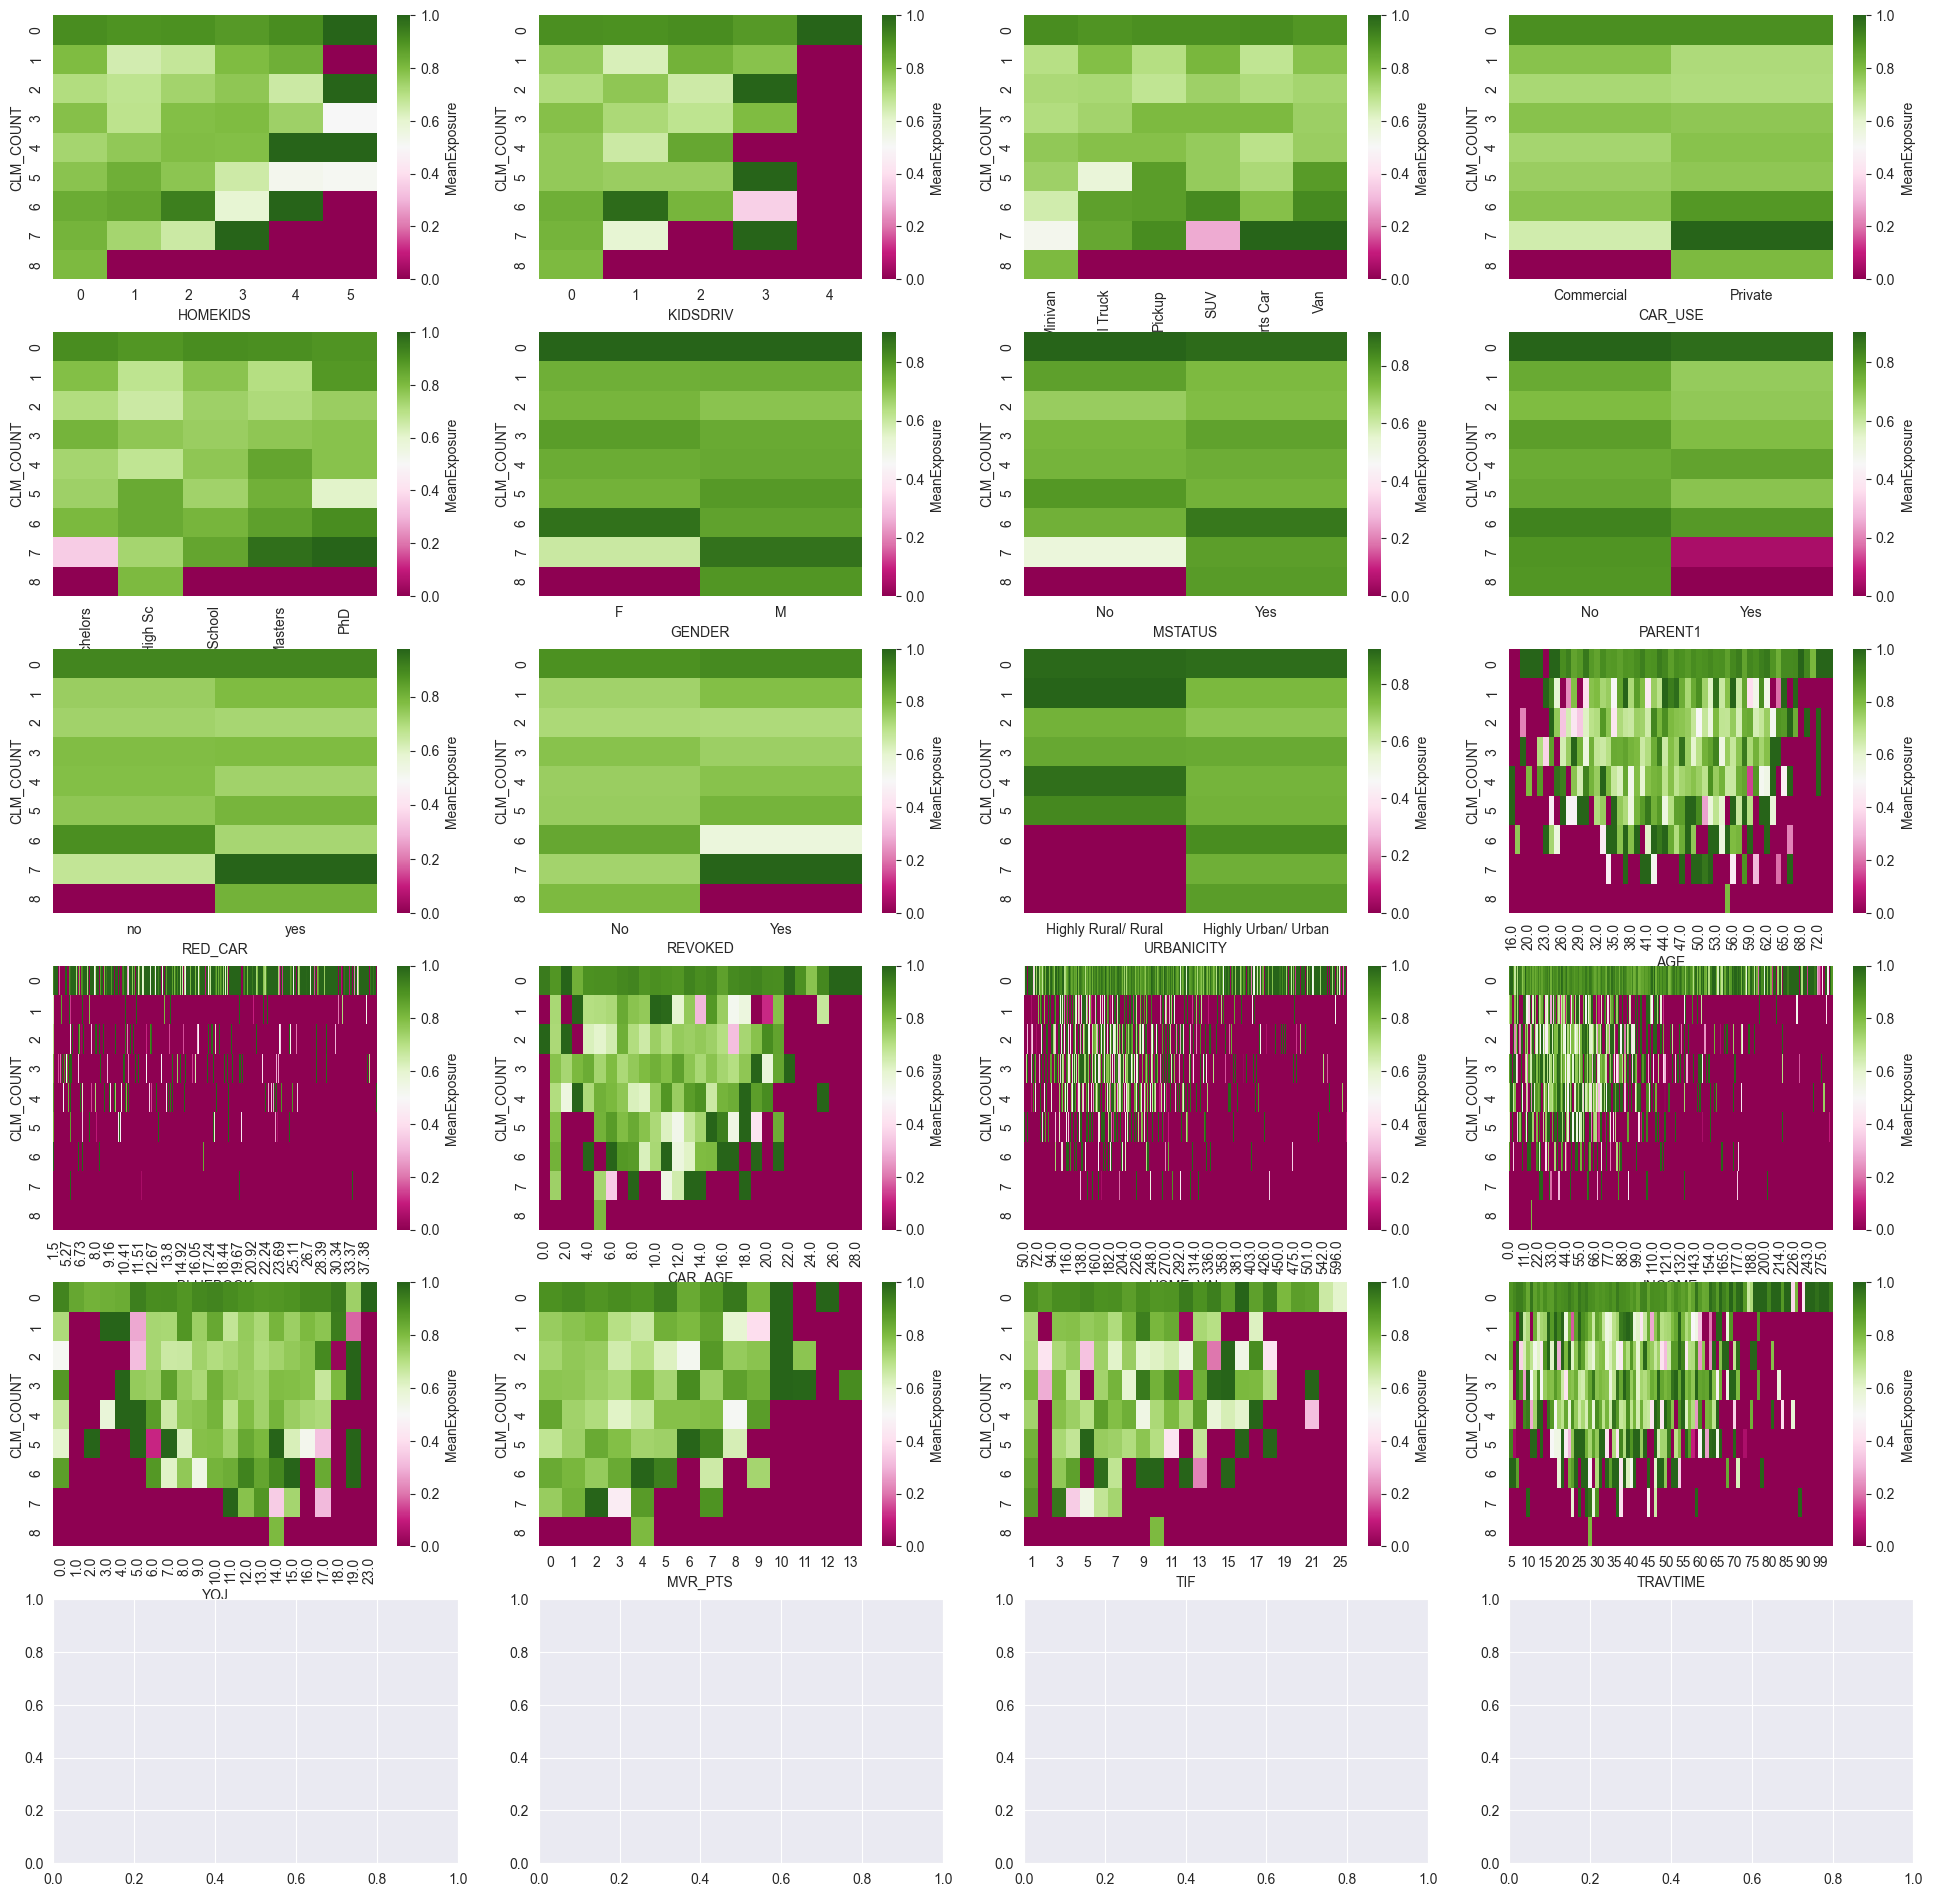

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

In [32]:
# Display relationship in heatmap
n_col = 4
n_rows = round(len(int_pred)/n_col) + 1
fig,axs = plt.subplots(nrows=n_rows,ncols=n_col,figsize=(24,24))
counter = 0
row_counter = 0
# print(n_rows,n_col)
for pred in int_pred:
    # print(row_counter,counter)
    xtab = pandas.crosstab(train_data[target], train_data[pred], values = train_data[exposure], aggfunc=numpy.mean)
    xtab.fillna(0, inplace = True)
    plt.figure(figsize = (10,8), dpi = 200)
    ax = sns.heatmap(xtab, cmap = 'PiYG', cbar_kws = {'label': 'MeanExposure'},
    ax = axs[row_counter][counter])
    # ax.invert_yaxis()
    counter+=1
    if counter == 4:
        row_counter+=1
        counter = 0

In [38]:
n_sample = train_data.shape[0]
y_train = train_data[target]
o_train = numpy.log(train_data[exposure])
# Build a model with only the Intercept term
X_train = train_data[[target]]
X_train.insert(0, 'Intercept', 1.0)
X_train = X_train.drop(columns = target)
result = Regression.PoissonRegression (X_train, y_train, o_train)
outCoefficient = result[0]
outCovb = result[1]
outCorb = result[2]
llk = result[3]
nonAliasParam = result[4]
outIterationTable = result[5]
y_pred = result[6]
aic = -2*llk + 2*len(nonAliasParam)
bic = -2*llk + len(nonAliasParam)*math.log(n_sample)
print(aic,bic)

18406.381425109754 18413.032274685982


In [53]:
def create_categorical_value(df,column_name):
    u = df[column_name].astype('category')
    u_freq = u.value_counts(ascending = True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_df_type = pandas.get_dummies(pm)
    return term_df_type

In [66]:
# Run 1

step_summary

[['Intercept', 1, -9202.190712554877, nan, nan, nan]]

In [166]:
def run_against_all(df,init_cols,categorical_cols,previous_train,output_train,exposure_train,ll,dv):
    step_detail = []
    Regression_Output = None
    for i in init_cols:
        if i in categorical_cols:
            new_train = previous_train.join(create_categorical_value(df,i),rsuffix = i)
        else:
            new_train = previous_train.join(df[i],rsuffix = i)
        Regression_Output = Regression.PoissonRegression(new_train, output_train, exposure_train)
        ll_1 = Regression_Output[3]
        dv_1 = len(Regression_Output[4])
        deviance_chisq = 2 * (ll_1 - ll)
        deviance_df = dv_1 - dv
        deviance_sig = chi2.sf(deviance_chisq, deviance_df)
        step_detail.append([str(i), dv_1, ll_1, deviance_chisq, deviance_df,deviance_sig])
    step_df = pd.DataFrame(step_detail)
    chosen_value = step_df[step_df[5] == step_df[5].min()]
    return chosen_value.values, Regression_Output

In [78]:
pd.DataFrame(run_against_all(train_data,int_pred,cat_cols,X_train,y_train,o_train,ll,dv))

,0,1,2,3,4,5
8,URBANICITY,2,"-8,796.722613",810.9361989,1,2.261281474e-178


In [173]:
def forward_selector(data,target_col,exposure_col,init_cols,cat_columns):
    #First Run
    target_train = data[target_col]
    exposure_train = numpy.log(data[exposure_col])
    intercept_train = data[[target]]
    init = init_cols
    intercept_train.insert(0, 'Intercept', 1.0)
    intercept_train = intercept_train.drop(columns = target)
    intercept_result = Regression.PoissonRegression (X_train, y_train, o_train)
    step_summary = []
    ll = result[3]
    dv = len(result[4])
    deviance_sig = 0
    threshold = 0.01
    step_summary.append(['Intercept', dv, ll, numpy.nan, numpy.nan, numpy.nan])
    while (deviance_sig < threshold):
        run,s = run_against_all(data,init,cat_columns,intercept_train,target_train,exposure_train,ll,dv)
        run = run[0]
        if run[0] in cat_columns:
            intercept_train = intercept_train.join(create_categorical_value(data,run[0]),rsuffix=str(run[0]))
        else:
            intercept_train = intercept_train.join(data[run[0]],rsuffix=str(run[0]))
        ll = run[2]
        dv= run[1]
        deviance_sig = run[5]
        init.remove(run[0])
        # print([ll,dv,deviance_sig,counter])
        if(deviance_sig<threshold):
            step_summary.append([run[0], dv, ll, run[3], run[4], run[5]])
    # print(intercept_train)
    step_summary = pd.DataFrame(step_summary)
    return step_summary, s

In [174]:
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED","URBANICITY",'HOMEKIDS', 'KIDSDRIV',"AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
df,outps = forward_selector(train_data,target,exposure,int_pred,cat_cols)

In [176]:
outps[0]

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Exponentiated
Intercept,-0.4677718175,0.08479014197,-0.633957442,-0.301586193,0.62639644
Highly Rural/ Rural,-1.940377902,0.08161937784,-2.100348943,-1.780406861,0.143649654
Highly Urban/ Urban,0.0,0.0,0.0,0.0,1.0
PhD,0.1491546468,0.07700637793,-0.001775080551,0.3000843741,1.160852497
Below High Sc,0.4696863588,0.05521379222,0.3614693145,0.577903403,1.599492448
Masters,-0.06832176654,0.0554462187,-0.1769943583,0.0403508252,0.9339599082
High School,0.4008037803,0.04484172942,0.3129156056,0.4886919549,1.493024279
Bachelors,0.0,0.0,0.0,0.0,1.0
MVR_PTS,0.08079890267,0.006532880331,0.0679946925,0.09360311283,1.084152854
Panel Truck,-0.03371667924,0.08031670403,-0.1911345265,0.123701168,0.9668453932


In [ ]:
# step_detail = []
# # Build the model Intercept + HOMEKIDS + KIDSDRIV
# X_train = train_data[int_pred]
# X_train.insert(0, 'Intercept', 1.0)
# result = Regression.PoissonRegression (X_train, y_train, o_train)
# outCoefficient = result[0]
# outCovb = result[1]
# outCorb = result[2]
# llk = result[3]
# nonAliasParam = result[4]
# outIterationTable = result[5]
# y_pred = result[6]
# plt.figure(figsize = (8,4), dpi = 200)
# ec = plt.scatter(y_train, y_pred, c = train_data['EXPOSURE'])
# plt.xlabel('Number of Claims')
# plt.ylabel('Predicted CLM_COUNT')
# plt.xticks(range(10))
# plt.grid(axis = 'both', linestyle = 'dotted')
# plt.colorbar(ec, label = 'Exposure')
# plt.show()
# y_resid = y_train - y_pred
# plt.figure(figsize = (8,4), dpi = 200)
# ec = plt.scatter(y_train, y_resid, c = train_data['EXPOSURE'])
# plt.xlabel('Number of Claims')
# plt.ylabel('Simple Residual')
# plt.xticks(range(10))
# plt.grid(axis = 'both', linestyle = 'dotted')
# plt.colorbar(ec, label = 'Exposure')
# plt.show()